# Optimal Predictor Machine used with Mushroom.csv

Load required libraries and functions

In [1]:
library('data.table')
library('extraDistr')
library('foreach')
library('png')
source('tplotfunctions.R')
source('guessmetadata.R')
source('buildagent.R')
source('infer.R')
source('decide.R')
source('mutualinfo.R')
source('rF.R')
source('plotFsamples1D.R')
options(repr.plot.width=10*sqrt(2), repr.plot.height=10)

Warning message in match.arg(palette, names(.schemes), several.ok = FALSE):
"strings not representable in native encoding will be translated to UTF-8"


## Changing the csv file to fit with optimal machine
Here som changes are done to make sure that the optimal machine will run with the dataset. This includes limmiting the amount of data, as well as limmiting variates.



In [2]:
# Set the file path to your CSV file
file_path <- "../Datasett/mushrooms.csv"

# Set the full path for the output CSV file
output_file_path <- "../Datasett/modified_data.csv"

# Load the CSV file with comma as the separator and the first row as headers
data <- read.csv(file_path, header = TRUE, sep = ",")

# Specify the columns to keep
columns_to_keep <- c("class", "capShape", "capSurface", "capColor", "bruises", "odor", "gillAttachment", "gillSpacing", "gillSize", "gillSize", "gillColor", "stalkShape", "stalkRoot", "stalkSurfaceAboveRing", "stalkSurfaceBelowRing")#, "stalkColorAboveRing", "stalkColorBelowRing","veilType","veilColor","ringNumber","ringType","sporePrintColor","population","habitat")

# Subset the data to keep only the selected columns
data <- data[, columns_to_keep]

# Set the number of random rows to select (e.g., 500)
num_random_rows <- 1000

# Check if the dataset has at least num_random_rows rows
if (num_random_rows <= nrow(data)) {
  # Randomly sample num_random_rows rows
  random_rows <- sample(1:nrow(data), num_random_rows)

  # Subset the data based on the randomly selected rows
  data <- data[random_rows, ]

  # Save the modified data as a CSV file with the specified full path
  write.csv(data, file = output_file_path, row.names = FALSE)

  # Print the first few rows to verify
  head(data)
} else {
  cat("The dataset does not have enough rows for random sampling.\n")}


,class,capShape,capSurface,capColor,bruises,odor,gillAttachment,gillSpacing,gillSize,gillSize.1,gillColor,stalkShape,stalkRoot,stalkSurfaceAboveRing,stalkSurfaceBelowRing
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
7400,p,k,y,e,f,y,f,c,n,n,b,t,?,s,k
1610,e,x,s,n,f,n,f,w,b,b,k,t,e,f,f
5639,e,k,s,e,t,n,f,c,b,b,e,e,?,s,s
2194,e,x,y,e,t,n,f,c,b,b,u,t,b,s,s
3411,e,f,f,n,t,n,f,c,b,b,u,t,b,s,s
6725,p,x,y,e,f,s,f,c,n,n,b,t,?,s,k


Checking to see the amount of unique rows in the dataset.

In [3]:
# Assuming your data frame is named "data"
unique_rows <- !duplicated(data)

# Print the number of unique rows
print(paste0("Number of unique rows: ", nrow(data[unique_rows,])))


[1] "Number of unique rows: 513"


Creating matadatafile for the datasett. This tells us how many variates there are, as well as how many possible values each variate can have

In [4]:
guessmetadata(data = '../Datasett/modified_data.csv',
              file = "../Datasett/preliminary.csv")

## Building the agent

is done with the function `buildagent()`, which takes as input the metadata and training data, and output an object of class "agent".

In this exploration we build two agents:
- `opm10`: trained with 10 datapoints
- `opmall`: trained with all datapoints

In [5]:
#opm10 <- buildagent(metadata='meta_income_data_example.csv',
#                    data=fread('train-income_data_example.csv', header=TRUE)[1:10])
#
#opmall <- buildagent(metadata='meta_income_data_example.csv',
#                     data='train-income_data_example.csv')
opm10 <- buildagent(metadata = "../Datasett/preliminary.csv",
                     data = fread('../Datasett/modified_data.csv')[1:10])

opmall <- buildagent(metadata = "../Datasett/preliminary.csv",
                     data = fread('../Datasett/modified_data.csv'))

Checking for how many total variates times the amount of data.????

In [6]:
length(opmall$counts)

[1] 149299200

You can check the internal structure of the "agent" object with `str()`:

In [7]:
str(opmall)

List of 4
 $ counts   : num [1:2, 1:5, 1:3, 1:9, 1:2, 1:9, 1:2, 1:2, 1:2, 1:2, 1:12, 1:2, 1:5, 1:4, 1:4] 0 0 0 0 0 0 0 0 0 0 ...
  ..- attr(*, "dimnames")=List of 15
  .. ..$ class                : chr [1:2] "e" "p"
  .. ..$ capShape             : chr [1:5] "b" "f" "k" "s" ...
  .. ..$ capSurface           : chr [1:3] "f" "s" "y"
  .. ..$ capColor             : chr [1:9] "b" "c" "e" "g" ...
  .. ..$ bruises              : chr [1:2] "f" "t"
  .. ..$ odor                 : chr [1:9] "a" "c" "f" "l" ...
  .. ..$ gillAttachment       : chr [1:2] "a" "f"
  .. ..$ gillSpacing          : chr [1:2] "c" "w"
  .. ..$ gillSize             : chr [1:2] "b" "n"
  .. ..$ gillSize.1           : chr [1:2] "b" "n"
  .. ..$ gillColor            : chr [1:12] "b" "e" "g" "h" ...
  .. ..$ stalkShape           : chr [1:2] "e" "t"
  .. ..$ stalkRoot            : chr [1:5] "?" "b" "c" "e" ...
  .. ..$ stalkSurfaceAboveRing: chr [1:4] "f" "k" "s" "y"
  .. ..$ stalkSurfaceBelowRing: chr [1:4] "f" "k" "s" "y"
 $ 

The "agent" object internally contains a parameter `alpha` expressing its guess of how many training data (just as a order of magnitude in base-2) would be needed to make reliable inferences about the full population.

Here are several guesses with their probabilities; you see that most probable is around 2000 training datapoints:

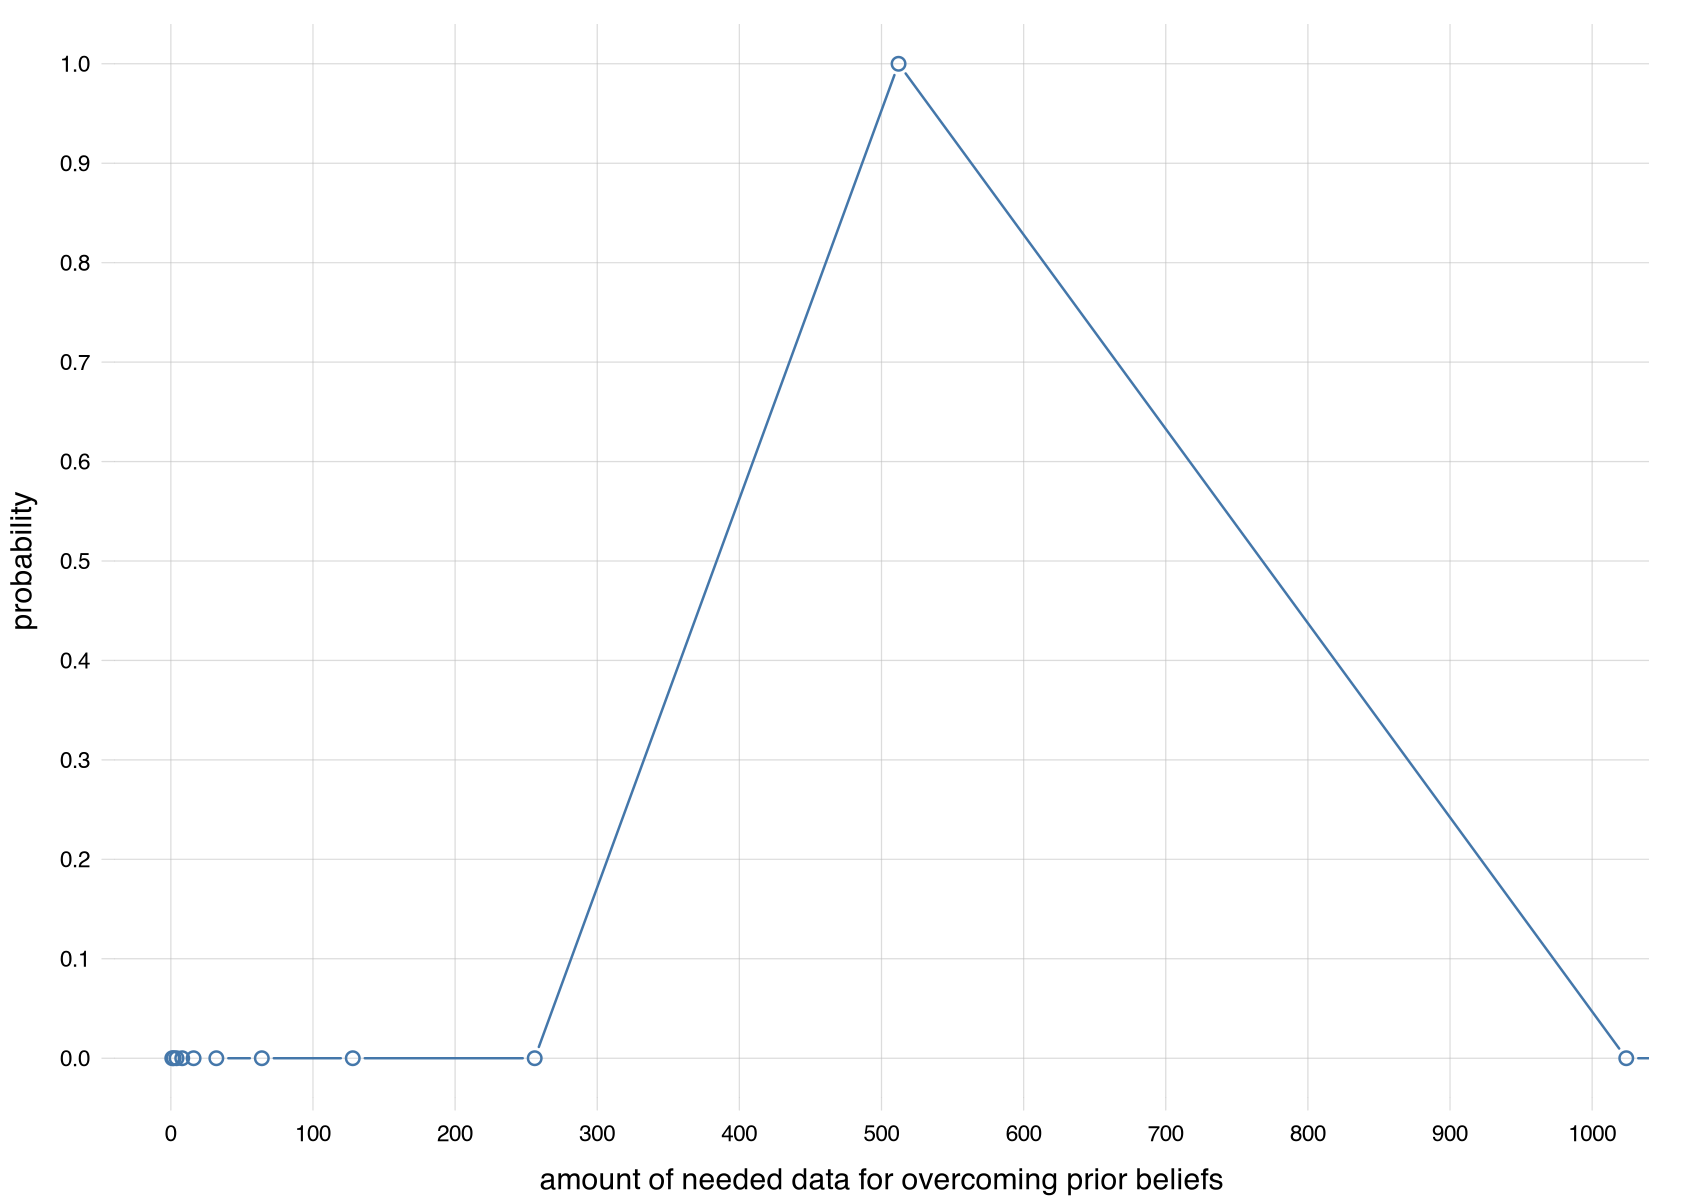

In [8]:
tplot(x=opmall$alphas, y=opmall$palphas, type='b',
      xlim=c(0, 1000), ylim=c(0, NA),
      xlab='amount of needed data for overcoming prior beliefs', ylab='probability')

## Only predictands, no predictors ("unsupervised-learning mode")

Let the little-trained agent forecast `income` for next unit

In [9]:
print(infer(agent=opm10, predictand='Na'))

Discarding all predictands: none matches allowed ones



ERROR: Error: vector memory exhausted (limit reached?)


The agent is internally checking *all possible* population-frequency distributions. It can therefore forecast how its probabilities could change *if more training data were provided*:

In [ ]:
plotFsamples1D(agent=opm10, n=600, predictand='class',
               ylim=c(0,1), main='opm10') # last options are for plotting

Now let's check the inference drawn by the fully-trained agent

In [ ]:
print(infer(agent=opmall, predictand='class'))

Also this agent can tell us how much would new training data change its inference:

In [ ]:
plotFsamples1D(agent=opmall, n=600, predictand='class',
               ylim=c(0,1), main='opmall')

We can draw inferences in the same way for any other variate, e.g. `capColor`.

This is the inference by the `opm10` agent:

In [ ]:
plotFsamples1D(agent=opm10, n=600, predictand='capColor',
               ylim=c(0,1), main='opm10')  # last options are for plotting

...and by the `opmall` agent:

In [ ]:
plotFsamples1D(agent=opmall, n=600, predictand='capColor',
               ylim=c(0,1), main='opmall')  # last options are for plotting

The agent can also draw inferences about several joint variates.

For instance `class` and `capColor` (let's show percentages and round to one decimal):

In [ ]:
result <- infer(agent=opmall, predictand=c('class', 'capColor'))

print(round(result*100, 1))


## Using predictors ("supervised-learning mode")

Suppose we know that `capSurface='y'` and `capColor='f'` for the new unit. What can the `class` be?

In [ ]:

result <- infer(
    agent = opmall, predictand = "class",
    predictor = list(capShape = "f", capSurface = "y", capColor = "n", gillAttachment = "f", gillSpacing = "c", gillSize = "b")
)

print(round(result * 100, 1))


Also in this case we can ask how much this inference could be changed by new training data.

Note how the agent warns us that, with more training data, it could happen that the percentages would be reversed – observe the gray lines:

In [ ]:
plotFsamples1D(agent=opmall, n=600,
               predictand='class',
               predictor=list(capSurface = "y", capColor = "p"),
               ylim=c(0,1), main='opmall')

Another example: what's the probability for the possible `class`, if we know the present mushroom has  `capSurface = Black` and `capColor = p`?

In [ ]:
result <- infer(agent=opmall,
                predictand='class',
                predictor=list(capSurface = "y", capColor = "p"))

print(round(sort(result, decreasing=TRUE) * 100, 1))

plotFsamples1D(agent=opmall, n=500,
               predictand='class',
               predictor=list(capSurface = "y", capColor = "p"),
              ylim=c(0,NA), cex.axis=0.75)

## Inverting predictors and predictands ("generative mode")

We can also infer `occupation` and `sex` given any value of `income`

In [ ]:
result <- infer(agent=opmall, predictand=c('capSurface', 'capColor'),
                predictor=list(class='e'))

print('e = edible')
print(round(result * 100, 2))

cat('\n\n') # some newlines


result <- infer(agent=opmall, predictand=c('capSurface', 'capColor'),
                predictor=list(class='p'))

print('p = poisonus')
print(round(result * 100, 2))

----

## The `rF()` function

This function generates **full-population** frequency distributions (even for subpopulations) that are probable according to the data.

For instance, let's see three samples of how the full-population frequency distribution for `sex` and `income` (jointly) could be:

In [ ]:
result <- rF(agent=opmall, n=3, predictand=c('capSurface', 'capColor'))

print(aperm(result) * 100) # permutation so that the samples are the last array dimension

These possible full-population frequency distributions can be used to assess how much the probabilities we find could change, if we collected a much, much larger amount of training data.

In the example below, we generate 1000 frequency distributions for `occupation` & `sex` given `income == >50K`, and then take the standard deviations of the samples as a rough measure of how much the probabilities we calculated a couple of cells above could change:

In [ ]:
freqsamples <- rF(n=1000, agent=opmall, predictand=c('capSurface', 'capColor'),
                  predictor=list(class='e'))

variability <- apply(freqsamples,
                     c('capSurface', 'capColor'), # which dimensions to apply
                     sd) # function to apply to those dimensions

print(round(variability * 100, 2)) # round to two decimals

----

## Calculating relevance of predictors

The agent can calculate the mutual information (measured in shannons) between any two sets of variates `A` and `B` of our choice, with the function `mutualinfo(probs, A, B)`. The joint probabilities for `(A,B)` must first be calculated with `infer()`.

For instance, what is the mutual information between `occupation` and `marital status`? The mutual information in this case can be anywhere between 0 Sh and 1 Sh 

(We print the result with 4 significant digits)

In [ ]:
probs <- infer(agent=opmall, predictand=c('class', 'capSurface', 'capColor'))

result <- mutualinfo(probs=probs, A='class', B=c('capSurface', 'capColor'))

print(paste0(signif(result, 4), ' Sh'))

Let’s consider a scenario where, in order to save resources, we can use *only one* variate in order to infer the income. Which of the other variates should we prefer?

We can calculate the mutual information between each of them and `income`:

In [ ]:
## list of all variates
variates <- names(dimnames(opmall$counts))

## list of all variates except 'income'
predictors <- variates[variates != 'class']

## prepare vector to contain the mutual information between each of these possible variates and 'income'
relevances <- numeric(length(predictors))
names(relevances) <- predictors

## calculate joint probability and then mutual information (shannons)
## of 'income' and another variate
for(var in predictors){
    probs <- infer(agent=opmall, predictand=c('class',var)) # calculation of joint probabilities
    relevances[var] <- mutualinfo(probs=probs, A='class', B=var) # calculation of mutual information
}

## output the mutual informations in decreasing order
print(round(sort(relevances, decreasing=TRUE), 4))

The most informative *single* predictor is `marital_status`, the least informative is `race`.

----

# Exercise

Now consider the scenario where we must *exclude one variate* from the eight predictors, or, equivalently, we can only use seven variates as predictors. Which variate should we exclude?

Prepare a script similar to the one above: it should calculate the mutual information between `income` and the other predictors but with one omitted, omitting each of the eight predictors in turn.

- Which single variate should not be omitted from the predictors? which single variate could be dropped?

- Do you obtain the same relevance ranking as in the “use-one-variate-only” scenario above?

**WARNING:** this computation could even take 10 min or more!

----


## Making decisions

The agent can make decisions with an arbitrary set of available choices and utilities. The function `decide()` is used for this. It takes as input the probabilities of the uncertain variate, which must first be calculated with `infer()`, and the utilities.

As an example, let's imagine that a bank has three loan options `loan_A`, `loan_B`, `loan_C` which yield different utilities depending on the person's income, which however is unknown (unrealistic, I know; but imagine it's the income in ten years).

Let's build the utility matrix first:

In [ ]:
## Warning: in R, matrices are filled column-wise: column 1 first, then column 2, then column 3, and so on
loanutilities <- matrix(c(-4,-1,0, 0,-1,-4), nrow=3, ncol=2, 
                  dimnames=list(loan=c('loan_A','loan_B','loan_C'), income=c('<=50K','>50K')))

print(loanutilities)

Now a `race='Black'`, `sex='Female'` person with `occupation='Sales'` asks for a loan. What should the bank decide?

We let the `opmall`-agent calculate the probabilities, and then make the optimal decision:

In [ ]:
incomeprobs <- infer(agent=opmall, predictand='income', predictor=list(race='Black', sex='Female', occupation='Sales'))

optimalchoice <- decide(probs=incomeprobs, utils=loanutilities)

print(incomeprobs)
cat('\n')
print(optimalchoice)              

Another customer comes in: a `race='White'`, `sex='Male'` person with `occupation='Exec-managerial'`. What's the optimal loan type for this customer?

In [ ]:
incomeprobs <- infer(agent=opmall, predictand='income', predictor=list(race='White', sex='Male', occupation='Exec-managerial'))

optimalchoice <- decide(probs=incomeprobs, utils=loanutilities)

print(incomeprobs)
cat('\n')
print(optimalchoice)

In [ ]:
testdata <- fread('test-income_data_example.csv', header=TRUE) # read test data
ntest <- nrow(testdata) # number of test data

testprobs <- numeric(ntest) # prepare vector of probabilities
testhits <- numeric(ntest) # prepare vector of hits

stopwatch <- Sys.time() # record time

for(i in 1:ntest){
    ## calculate probabilities given all variates except 'income'
    probs <- infer(agent=opmall, predictor=testdata[i, !'income'])

    ## store the probability for <=50K
    testprobs[i] <- probs['<=50K']

    ## decide on one value, check if decision == true_value, and store result
    chosenvalue <- decide(probs=probs)

    testhits[i] <- (chosenvalue == testdata[i, 'income'])
}

print(Sys.time() - stopwatch) # print computation time


## Histogram and average
thist(testprobs, n=seq(0,1,length.out=10), plot=TRUE,
      xlab='P(income = "<=50K")',
      ylab='frequency density in test set',
      main=paste0('accuracy: ', round(100*mean(testhits), 1), '%'))